In [1]:
import random
import numpy as np  
import torch
import matplotlib.pyplot as plt
from functools import partial
from os.path import dirname, join as pjoin
import scipy
import scipy.io as sio

from accuracy_bounds.data.generator_functions import random_uni_points_in_ball
from accuracy_bounds.utils.visualizations import plot_wckersize_conv, plot_avkersize_conv, visualize_ball_3d
from accuracy_bounds.algo.kernel_size import compute_wc_kernel_size, compute_av_kernel_size
from accuracy_bounds.algo.projections import apply_forwardmodel
from accuracy_bounds.data.dataset import GeneratorDataset
from accuracy_bounds.utils.utils import set_seed

### **Example 2:** Worst Case Kernel Size over Flouresence Microscopy Data

In [2]:
# Get the filename for an example .mat file from the  examples/flourescencemicroscopy directory.
#data_dir1 = '/Users/Nins/Documents/CodeProjects/UPE/universal-performance-estimator/examples/flourescencemicroscopy/initial_data_extended/data_S1'
#data_dir1 = '/Users/Nins/Documents/CodeProjects/UPE/universal-performance-estimator/examples/flourescencemicroscopy/initial_data_extended/data_S1'
#data_dir1=  '/Users/Nins/Documents/CodeProjects/UPE/universal-performance-estimator/examples/flourescencemicroscopy/data_S2'
data_dir1 = '/Users/Nins/Documents/CodeProjects/UPE/universal-performance-estimator/examples/flourescencemicroscopy/data_S3'

### Construct Feasible Sets for 1 Example of Flouresence Microscopy Data (I=1)

In [3]:
def load_xy_components(mat_contents):
    """ Load xyz components per example, i.e. one measurement w, from matrix.
    Args:
        -mat_contents, dictionary
    Returns: 
        -feas: xyz component feasible set for measurement of matrix."""

    x = np.array(mat_contents['x_grnd']).flatten()
    xm=np.array(mat_contents['x_mcmc']).flatten()
    x=np.concatenate((x,xm), axis=None)

    y = np.array(mat_contents['y_grnd']).flatten()
    ym=np.array(mat_contents['y_mcmc']).flatten()
    y=np.concatenate((y,ym), axis=None)

    # z is zero currently
    #z = np.array(mat_contents['z_grnd']).flatten()
    #zm=np.array(mat_contents['z_mcmc']).flatten()
    #z=np.concatenate((z,zm), axis=None)

    #create feasible set for one measurement
    f_xy= np.stack((x,y), axis=1)
    return f_xy

In [4]:
def load_ch_components(mat_contents):
    """ Load ch components per example, i.e. one measurement w, from matrix.
    Args:
        -mat_contents, dictionary
    Returns: 
        -feas: ch component feasible set for measurement of matrix."""

    c = np.array(mat_contents['C_grnd']).flatten()
    cm=np.array(mat_contents['C_mcmc']).flatten()
    c=np.concatenate((c,cm), axis=None)

    h = np.array(mat_contents['h_grnd']).flatten()
    hm=np.array(mat_contents['h_mcmc']).flatten()
    h=np.concatenate((h,hm), axis=None)

    #create feasible set for example 001
    f_ch= np.stack((c,h), axis=1)
    return f_ch

In [5]:
# get list of xy feasible set data for each measurement, i.e. one example_00x.mat file corresponds to one measurement
feasible_sets_list = []
for i in range(1,6):      
  mat = pjoin(data_dir1, f"example_{str(i).zfill(3)}.mat")
  # Load the .mat file contents
  mat_contents = sio.loadmat(mat)
  # get xy feasible set from example i
  f_xy=load_xy_components(mat_contents)
  # add feasible set to list of feasible sets
  feasible_sets_list.append(f_xy)


In [6]:
print(len(feasible_sets_list))

5


### **Example 2:** Kernel Sizes for Example Flouresence Microscopy Data

In [7]:
def compute_wc_av_diams_feas(feas):
    """" Compute average and worst case diams with the l2 norm for one feasible set.
    Args:
        -feas: array of elements in one feasible set
    Returns: 
        - diameter_mean_y: average diameter of feas (feasible set)
        - num_feas: number of elements in feas (feasible set)
        - max_diam_Fy: largest diameter of feas (feasible set)
    """
    max_diam_Fy = 0
    diameter_mean_y = 0
    diam_y = []
    num_feas = np.array(np.shape(feas))[0].astype(int)
    # compute diameters
    for h in range(0,num_feas,1):
        for j in range(0,h+1,1):
            #compute vectors in null space of F and their norm
            dist_ns = feas[h]-feas[j]
            diameter= np.linalg.norm(dist_ns, ord = 2)

            #add to diam_y 
            diam_y.append(diameter)

            #get ascending diams
            if diameter > max_diam_Fy:
                max_diam_Fy = diameter
                            
    # get mean over diams, with factor 2 due to symmetry of the norm of the compute vectors in null space of F (norm(x-z)=norm(z-x))
    # and divided by num_feas^2 ad we have that many terms
    if num_feas > 0:      
        # compute 2 times sum over diams to the power p divided by num_feas^2
        diameter_mean_y = 2*np.divide(np.sum(np.power(diam_y,2)), np.power(num_feas,2))
    elif num_feas==0:
        diameter_mean_y = 0  

    return diameter_mean_y, num_feas, max_diam_Fy
    

### Compute worst case and average kernel size per example

In [8]:
print(feasible_sets_list[0][:3])

[[-0.02157566 -0.00564856]
 [-0.02176735 -0.00492716]
 [-0.02101383 -0.00688552]]


In [25]:
# test convergence over number of points in feasible sets for first example
#get 2 times sqrt of average kernel size per sample
n = len(feasible_sets_list[0])
av_diameters = []

for i in range(0,n, 50):
    #print(compute_wc_av_diams_feas(feasible_sets_list[i]))
    av_diameters.append(compute_wc_av_diams_feas(feasible_sets_list[4][:i])[0])
    
av_diameters=np.array(av_diameters)
kernel_size= np.power(av_diameters, 0.5)
kernel_size_nm= np.multiply(kernel_size, 1000)

print(kernel_size_nm)

[0.         2.8415152  2.85543748 2.87102493 2.82649799 2.81318779
 2.82715057 2.7981219  2.76494768 2.77463409 2.82208074 2.82813266
 2.81502014 2.83040931 2.8175109  2.8012046  2.79776316 2.79624276
 2.76817678 2.76080174 2.74672961 2.74036608 2.72775071 2.73755124
 2.72516934 2.71007017 2.71478127 2.71017035 2.70221677 2.71838531
 2.71788065 2.71657412 2.707887   2.70671777 2.69054071 2.6919823
 2.70243654 2.69429112 2.69269822 2.69463845 2.69967068 2.69175317
 2.69112498 2.68310133 2.69592919 2.6997443  2.712789   2.7112751
 2.70845464 2.70469316 2.70957021 2.71290087 2.70885232 2.71853905
 2.71170801 2.71506384 2.71465268 2.72161466 2.72089757 2.71351652
 2.70764062 2.70229018 2.70787231 2.7105189  2.71624886 2.71219643
 2.71339294 2.71005374 2.71374859 2.71544737 2.7132579  2.71360534
 2.71512953 2.71153304 2.71172987 2.70303295 2.71227158 2.70706128
 2.70804238 2.70725629 2.7137515 ]


In [26]:
def plot_avkersize_conv(av_kersize, av_kersizes, ker_size, max_k):

    # Plot results
    x_axis = np.arange(1, max_k+1,50)
    y_axis = np.array(av_kersizes)
    plt.plot(x_axis, y_axis)
    plt.axhline(ker_size, color='r')
    plt.ylim(0, ker_size + 0.3 * ker_size)
    plt.grid()
    plt.xlabel("Number of samples in feasible set")
    plt.ylabel("Approximate average kernel size nm")
    plt.title("Number of Samples vs Av. Kernel Size")
    plt.show()

    #max_diameter_total = max(max_diameters)
    print(f"Total Max Kernel Size: {av_kersize}")
    print(f"Analytical Kernel Size: {ker_size}")
    rel_error = (av_kersize - ker_size) / ker_size
    print(f"Relative Error: {rel_error}")

In [ ]:
def plot_avkersize_conv(av_kersize1, av_kersize2, av_kersize3, av_kersize4, av_kersize5, av_kersize, ker_size, max_k):

    # Plot results
    x_axis = np.arange(1, max_k+1,50)
    y_axis = np.array(av_kersize1)
    y_axis = np.array(av_kersize2)
    y_axis = np.array(av_kersize3)
    y_axis = np.array(av_kersize4)
    y_axis = np.array(av_kersize5)
    plt.plot(x_axis, y_axis)
    plt.axhline(ker_size, color='r')
    plt.ylim(0, ker_size + 0.3 * ker_size)
    plt.grid()
    plt.xlabel("Number of samples in feasible set")
    plt.ylabel("Approximate average kernel size nm")
    plt.title("Number of Samples vs Av. Kernel Size")
    plt.show()

    #max_diameter_total = max(max_diameters)
    print(f"Total Max Kernel Size: {av_kersize}")
    print(f"Analytical Kernel Size: {ker_size}")
    rel_error = (av_kersize - ker_size) / ker_size
    print(f"Relative Error: {rel_error}")

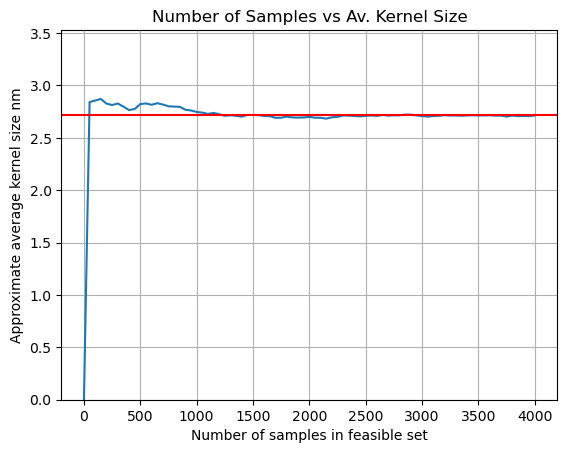

Total Max Kernel Size: 2.713751497039316
Analytical Kernel Size: 2.713751497039316
Relative Error: 0.0


In [27]:
plot_avkersize_conv(kernel_size_nm[-1], kernel_size_nm, kernel_size_nm[-1], 4050)

In [ ]:
#get 2 times sqrt of average kernel size per sample
av_diameters = []
diameters = []

for i in range(0,5):
    #print(compute_wc_av_diams_feas(feasible_sets_list[i]))
    av_diameters.append(compute_wc_av_diams_feas(feasible_sets_list[i])[0])
    diameters.append(compute_wc_av_diams_feas(feasible_sets_list[i])[2])
    
diameters=np.array(diameters)
diameters= np.multiply(diameters, 1000)
av_diameters=np.array(av_diameters)
kernel_size= np.power(av_diameters, 0.5)
kernel_size_nm= np.multiply(kernel_size, 1000)

print(kernel_size_nm)
print(diameters)

IndexError: list index out of range

In [ ]:
#def make_latex_table(average_ker,wc_ker):
for i in range(len(diameters)):
    x =  f"example {str(i+1).zfill(3)} &"+str(round(kernel_size_nm[i],4))+"nm &"+str(round(diameters[i],4))+"nm \\"+"\\"
    print(x)


example 001 &2.6617nm &7.1187nm \\
example 002 &2.798nm &7.8053nm \\
example 003 &2.3207nm &8.1592nm \\
example 004 &2.6239nm &8.0121nm \\
example 005 &2.8839nm &7.3012nm \\
example 006 &2.6576nm &6.8111nm \\
example 007 &2.4356nm &6.8314nm \\
example 008 &2.5332nm &6.7227nm \\
example 009 &2.6309nm &7.3812nm \\
example 010 &2.3895nm &7.1032nm \\
example 011 &2.9275nm &7.9958nm \\
example 012 &2.7452nm &6.8712nm \\
example 013 &2.9445nm &7.9899nm \\
example 014 &2.6892nm &8.4863nm \\
example 015 &2.5428nm &7.2612nm \\
example 016 &2.8487nm &7.7055nm \\
example 017 &2.3876nm &6.4911nm \\
example 018 &2.7159nm &7.6748nm \\
example 019 &3.0554nm &8.4776nm \\
example 020 &9.1534nm &36.4151nm \\
example 021 &2.681nm &7.1264nm \\
example 022 &2.7495nm &8.163nm \\
example 023 &2.7658nm &8.5662nm \\
example 024 &2.441nm &6.1262nm \\
example 025 &2.6244nm &7.9561nm \\


In [ ]:
# get average kernel size 
for i in range(0,25):
    print(compute_wc_av_diams_feas(feasible_sets_list[i]))

(7.08467938396992e-06, 81, 0.007118734622805287)
(7.828595393018401e-06, 81, 0.007805262321649174)
(5.385675439971957e-06, 81, 0.008159163925116685)
(6.884948287284288e-06, 81, 0.008012083354346215)
(8.316609141691955e-06, 81, 0.007301169921982575)
(7.0627269075010704e-06, 81, 0.006811096849134475)
(5.932183900963606e-06, 81, 0.006831401714645405)
(6.4170731257003384e-06, 81, 0.006722685979925854)
(6.921619174668224e-06, 81, 0.007381190743045164)
(5.709657640590748e-06, 81, 0.007103214190511283)
(8.57042216187834e-06, 81, 0.007995789892260529)
(7.53631283667922e-06, 81, 0.006871151456793051)
(8.670318861711457e-06, 81, 0.007989888231951271)
(7.231781777918624e-06, 81, 0.008486287144679538)
(6.466067795632375e-06, 81, 0.007261186887280173)
(8.114833706861323e-06, 81, 0.007705493153886832)
(5.700465124840091e-06, 81, 0.006491097932315898)
(7.3760173768553226e-06, 81, 0.00767478719834904)
(9.335456876409661e-06, 81, 0.008477605822927912)
(8.378423103914589e-05, 81, 0.03641510257937209)
(7

### Compute  worst case and average kernel size over all examples

In [ ]:

def av_kernelsize(feasible_sets_list, p=2):
    """
    Computes the average kernel size for a noisy inverse problem under Algorithm 2.

    Args:
        - feasible_sets_list: list of feasible sets
        - p: order of the norm, default p=2 for MSE computation.

    Returns:
        Approximate average kernel size for for a set of input data samples.
    """

    av_kersizep = 0
    num_samples = len(feasible_sets_list)

    for i in range(0,num_samples):
        # compute diameter of feasible set for one input data point (num_feas will be used for statistics later on)
        diameter_mean_y, num_feas, max_diam_Fy = compute_wc_av_diams_feas(feasible_sets_list[i])
        #add diameters means for obtaining average kersize to the power p
        av_kersizep = av_kersizep + diameter_mean_y
        
    # get mean over input data
    av_kersize = np.divide(av_kersizep, num_samples)    
    # take power 1/p to obtain average kersize
    av_kersize =  np.power(av_kersize, 1/p)
    
    return av_kersize


In [ ]:
print(np.multiply(av_kernelsize(feasible_sets_list, p=2),1000))

3.197324870400484


In [ ]:
def wc_kernelsize(feasible_sets_list, p=2):
    """
    Computes the worst-case kernel size for noisy inverse problem using Algorithm 1.

    Args:
        - feasible_sets_list: list of feasible sets
        - p: order of the norm, default p=2 for MSE computation.

    Returns:
        Approximate worst-case kernel size for a set of input data samples.
    """
    wc_kersize =0

    num_samples = len(feasible_sets_list)

    for i in range(0,num_samples):
        # compute diameter of feasible set for one input data point
        diameter_mean_y, num_feas, max_diam_Fy = compute_wc_av_diams_feas(feasible_sets_list[i])
        if max_diam_Fy > wc_kersize:
            wc_kersize = max_diam_Fy
    
    return wc_kersize

In [ ]:
print(wc_kernelsize(feasible_sets_list, p=2))

0.03641510257937209


### Visualize feasible sets

In [ ]:
# get three dim positions 
new_list_of_arrays = []
k=len(feasible_sets_list)
for i in range(k):
    for j in range(81):
        x=np.multiply(np.array(feasible_sets_list)[i,j],1000)
        new_list_of_arrays.append(np.append(x,0))

# get positions in nm
#np.multiply(new_list_of_arrays, 1000)
print(new_list_of_arrays)


[array([-66.23104464, -51.59829376,   0.        ]), array([-67.87679797, -50.21857976,   0.        ]), array([-65.39537799, -52.93099157,   0.        ]), array([-65.52612385, -52.78670545,   0.        ]), array([-66.5126141, -52.0183588,   0.       ]), array([-66.94875136, -50.87719168,   0.        ]), array([-67.02418481, -52.99766916,   0.        ]), array([-67.18306684, -53.03657642,   0.        ]), array([-67.81813784, -52.17787956,   0.        ]), array([-66.20921764, -48.92429964,   0.        ]), array([-66.20921764, -48.92429964,   0.        ]), array([-69.43787346, -51.86149967,   0.        ]), array([-68.1171808 , -52.45479298,   0.        ]), array([-65.97433547, -52.52965078,   0.        ]), array([-63.75735726, -52.82535659,   0.        ]), array([-66.44445847, -50.49475937,   0.        ]), array([-65.09732717, -53.89722807,   0.        ]), array([-65.28036875, -52.30188913,   0.        ]), array([-67.07787854, -52.48319694,   0.        ]), array([-66.39648756, -53.97505178

In [ ]:
def visualize_ball_3d(points, 
                      ax=None, 
                      radius=1, 
                      center=(0,0,0),
                      title="3D Ball with Points Inside",
                      x_axis="X nm",
                      y_axis="Y nm",
                      z_axis="Z"):

    n_points, dim = points.shape
    assert dim == 3, f"Only 3D points accepted. Given shape: {points.shape}"

    if not ax:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

    ax.scatter(points[:, 0], points[:, 1], points[:, 2], alpha=0.5, label='Points')

    u, v = np.mgrid[0:2 * np.pi:40j, 0:np.pi:20j]
    x = radius * np.cos(u) * np.sin(v) + center[0]
    y = radius * np.sin(u) * np.sin(v) + center[1]
    z = radius * np.cos(v) + center[2]
    ax.plot_wireframe(x, y, z, color='r', alpha=0.2, linewidth=0.5)

    ax.set_xlim([-radius, radius])
    ax.set_ylim([-radius, radius])
    ax.set_zlim([-radius, radius])
    ax.set_title(title)
    ax.set_xlabel(x_axis)
    ax.set_ylabel(y_axis)
    ax.set_zlabel(z_axis)

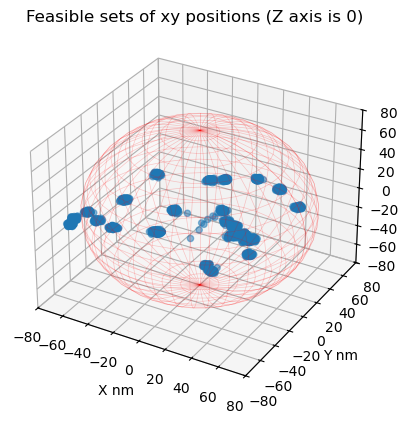

In [ ]:
radius = 80
center = [0,0,0]
new_list_of_arrays = np.array(new_list_of_arrays)


visualize_ball_3d(points=new_list_of_arrays, radius=radius, center=center, title="Feasible sets of xy positions (Z axis is 0)")

### Setup WC-Kernal Size Computation

In [ ]:
max_k = 300
input_target_pairs = 500

##### Compute Worst-Case Kernel Size

In [ ]:
wc_kersizes = compute_wc_kernel_size(A, input_data[:input_target_pairs], target_data[:input_target_pairs], p, q, epsilon, max_k)
wc_kersize_final = wc_kersizes[-1]

plot_wckersize_conv(wc_kersize_final, wc_kersizes, wc_kernel_size_analytical, max_k)


NameError: name 'A' is not defined

### Setup AV-Kernal Size Computation

In [ ]:
max_k = 150
input_target_pairs = 1000

AV-Kernel Size: 1.349903482127652


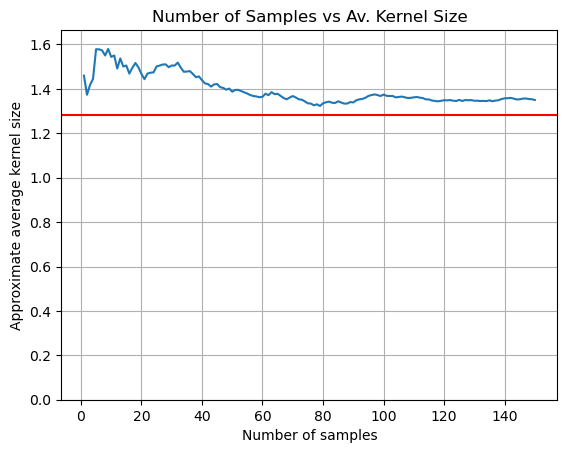

Total Max Kernel Size: 1.349903482127652
Analytical Kernel Size: 1.2805791649874942
Relative Error: 0.05413512810106891


In [ ]:

av_kersizes = compute_av_kernel_size(A, input_data[:input_target_pairs], target_data[:input_target_pairs], p, q, epsilon, max_k)

av_kersizef = av_kersizes[-1]

plot_avkersize_conv(av_kersizef, av_kersizes, av_kernel_size_analytical, max_k)